# This notebook configures a CFM run for a single site, runs the CFM, and processes/plots the outputs.

### It should run if you put it in the CFM_main directory.

But it should still be considered in beta - please let me know if you have issues!

In [11]:
#!/usr/bin/env python

import numpy as np 
import pandas as pd
import xarray as xr
import glob
import io
import multiprocessing
import sys
import os
import time
import json
import shutil
from pathlib import Path


"""
runCFM_notebook.ipynb
=======
This notebook configures a CFM run and then runs it.
- it goes in CFM_main 

- Forcing data:
    - this example file uses a pickled dataframe with climate data (MERRA-2) for DYE-2 to force the CFM
    - these climate data come from a zarr store with MERRA-2 climate data
    - That zarr contains MERRA-2 climate fields that I have subsetted, getting just the variables
      from MERRA-2 that CFM needs for either Antarctica or Greenland.
    - the zarr store is here: https://zenodo.org/records/17317018. Note that the zarr is divided into 5 zip
      stores because of the file size. If you download them, put the 5 zips into a directory and update the 
      zarr_path below.

- this notebook creates a .json configuration file
- CFM runs with the climate input and config file, results get put
  in the specified directory.
"""

### CHANGE THESE PATHS TO MATCH YOUR FILESYSTEM
### set paths:
# cfm_path = Path('/Path/To/CommunityFirnModel/CFM_main') #You can use this if you want this notebook in a directory other than CFM_main
# zarr_path = Path('/Path/To/zarr')

cfm_path = Path('/Users/cdsteve2/research/firn/CommunityFirnModel/CFM_main')
zarr_path = Path('/Users/cdsteve2/nobackup/RCMdata/MERRA2/GrIS/zarr')
###

sys.path.append(str(cfm_path))

from firn_density_nospin import FirnDensityNoSpin
import RCMpkl_to_spin as RCM

In [7]:
### (optional) Set plot parameters (seaborn, matplotlib)
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
sb=True
if sb:
    sns.set()
    sns.set_context('paper', font_scale=1.5, rc={"lines.linewidth": 1.5})
#     sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    sns.set_style("whitegrid",{"xtick.top":True, "xtick.bottom":True,"ytick.left":True, "ytick.right":True})
# plt.style.use('seaborn-notebook')

# pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 500)
mpl.rcParams['axes.formatter.useoffset'] = False
mpl.rcParams.update({'figure.autolayout': True})
fontsz = 20

In [15]:
### specify latitude and longitude you want
### "lat_int" and "lon_int" are "latitude of interest" 
### and "longitude of interest"

### this is DYE2
lat_int = 66.5 
lon_int = -46.25 

### Summit:
# lat_int = 72.5 
# lon_int = -38.75 

### Or choose your own! (Requires zarr)
# lat_int = YY
# lon_int = XX

In [12]:
##########
### below function gets climate data to force from a zarr store
### get zarr from: https://zenodo.org/records/17317018

def MERRA2_zarr_to_dataframe(lat_int,lon_int,zarr_path=None):
    '''
    Create a pandas dataframe for a site in Greenland
    returns:
    df_daily: a dataframe holding all of the forcing fields needed for CFM run
    
    input mass fluxes from zarr are in kg/m2/s.
    mass fluxes in df_daily are in kg/m2/timestep
    energy fluxes are W/m2
    
    in MERRA, ?positive? sublimation flux = sublimation, ?negative? = deposition
    '''
    def make_dataframe(dsZ,lat_int,lon_int):
            lat_ll = dsZ.lat.data
            lon_ll = dsZ.lon.data
            ii, lat_val = min(enumerate(lat_ll), key=lambda x: abs(x[1]-lat_int))
            jj, lon_val = min(enumerate(lon_ll), key=lambda x: abs(x[1]-lon_int))

            df_sub = pd.DataFrame(index=dsZ.time.values)

            varlist = [jj for jj in dsZ.variables if jj not in ['time','lat','lon']]

            for vv in varlist:
                df_sub[vv] = dsZ.isel(lat=[ii],lon=[jj])[vv].values.flatten()

            _dt = float((dsZ.time.diff(dim='time')/1e9).mean()) # seconds per time step, to put mass flux units into kg/m2/timestep

            df_sub['RAIN'] = (df_sub['PRECLS']+df_sub['PRECCU']) * _dt
            df_sub['EVAP'] = df_sub['EVAP'] * _dt
            df_sub['PRECSN'] = df_sub['PRECSN'] * _dt
            df_sub['SMELT'] = df_sub['SMELT'] * _dt

            drn = {'T2M':'T2m','TS':'TSKIN','EVAP':'SUBLIM','HFLUX':'QH','EFLUX':'QL','SWGDN':'SW_d','LWGAB':'LW_d','RAIN':'RAIN','PRECSN':'BDOT','ALBEDO':'ALBEDO','SMELT':'SMELT'}

            df_sub = df_sub[drn.keys()]
            df_sub.rename(mapper=drn,axis=1,inplace=True)

            return ii,jj,lat_val,lon_val,df_sub
        
    decades = [1980,1990,2000,2010,2020]
    df_dict = {}
    if zarr_path is None: # this is old behavior. Now zarr_path is set in intro cell.
        zarr_path = Path('/Users/cdsteve2/nobackup/RCMdata/MERRA2/GrIS/zarr/')
    
    for decade in decades:
        file = Path(zarr_path,f'M2_GrIS_daily_IS2mc_{decade}.zarr.zip')
        with xr.open_dataset(file,engine='zarr') as dsZ:
            ii,jj,lat_val,lon_val,df_sub = make_dataframe(dsZ,lat_int,lon_int)
            df_dict[decade] = df_sub
            
    df_out = pd.concat(df_dict.values())

    df_out['QL'] = -1 * df_out['QL']
    df_out['QH'] = -1 * df_out['QH']

    return ii,jj,lat_val,lon_val,df_out

In [16]:
### OPTION 1: GET CLIMATE FORCING FROM THE ZARR

### Call the function to create a pandas dataframe with climamte forcing
### (need the zarr for this)
### optionally, save the dataframe as a pkl
### returns "lat_val" and "lon_val", which are "latitude value" 
### and "longitude value", i.e. the MERRA-2 grid point
### closest to lat_int and lon_int.

ii,jj,lat_val,lon_val,df_daily = MERRA2_zarr_to_dataframe(lat_int,lon_int,zarr_path=zarr_path) # make sure zarr_path is set correctly (first cell)
print(ii, jj, lat_val, lon_val)

save_df=True
save_format = '.pkl' # .csv or pkl

if save_df:
    if save_format=='.pkl':
        pd.to_pickle(df_daily,f'CFM_example_{lat_val}_{lon_val}.pkl')
    else: # csv
        df_daily.to_csv(f'CFMinput_example/CFM_example_{lat_val}_{lon_val}.csv')

23 54 66.5 -46.25


In [ ]:
### OPTION 2: LOAD CLIMATE DATA FROM AN EXTANT DATAFRAME
### (which is saved in .pkl or .csv file)
'''
If you already have the forcing data for the lat/lon pair pickled,
you can instead load it here.

This example notebooke only works with the provided example files.

But, you can also create your own dataframe with climate data
and load it here
If you are doing this you can mimic the format of the example files.
'''

lat_val = lat_int
lon_val = lon_int

### e.g.:

df_daily = pd.read_pickle(f'CFMinput_example/CFM_example_{lat_val}_{lon_val}.pkl')

### or:

# df_daily = pd.read_csv(f'CFMinput_example/CFM_example_{lat_val}_{lon_val}.csv')


This is the key bit to using the CFM this way - all of the forcing data goes into a pandas data frame with a datetime index.

Mass fluxes (ie., precip, sublimation) need to be in units $kg/m^{2}/dt$, where dt is the the time delta of the dataframe. I.e., if your dataframe is daily resolution, the units are $kg/m$^{2}$/day$. In this example, since it is 4-hourly, the mass fluxes are the kg/m2 from that 4 period.

so, with this information, hopefully you can make a working dataframe with your own climate data. Email me if you have questions or issues! maxstev@umd.edu

In [18]:
### The input dataframe
df_daily.head()

,T2m,TSKIN,SUBLIM,QH,QL,SW_d,LW_d,RAIN,BDOT,ALBEDO,SMELT
1980-01-01,253.803024,251.357666,0.082729,39.290516,-2.678296,0.068455,195.278625,0.0,0.017142,0.745410,0.0
1980-01-02,253.174332,250.510620,-0.122858,41.642860,3.984042,0.085696,184.553848,0.0,0.037053,0.748229,0.0
1980-01-03,253.290573,250.633118,-0.080217,33.256168,2.601641,0.106510,188.615723,0.0,0.180696,0.751027,0.0
1980-01-04,250.833420,248.367981,-0.089476,23.610435,2.901408,0.118594,194.989761,0.0,0.497599,0.754252,0.0
1980-01-05,255.097000,253.529221,0.074643,39.769558,-2.417284,0.073483,206.719543,0.0,0.893297,0.779712,0.0


In [19]:
### This function contains all of the CFM configuration options. You can change them, and the configuration gets stored as a .json file.
### The values here are more or less the defaults.

def makejson():
    false = False
    true = True
    c = {
    "InputFileFolder": "CFMinput",
    "InputFileNameTemp": "example_tskin.csv",
    "InputFileNamebdot": "example_smb.csv",
    "InputFileNameIso": "example_isotope.csv",
    "InputFileNamerho": "example_rhos.csv",
    "InputFileNamemelt": "example_melt.csv",
    "resultsFolder": "CFMoutput_example",
    "initfirnFile": "example_firndata.csv",
    "initprofile": false,
    "input_type": "dataframe",
    "input_type_options": ["csv","dataframe"],
    "DFresample": "1D",
    "DFfile": "MERRA2_CLIM_df_72.5_-38.75.pkl",
    "physRho": "GSFC2020",
    "physRho_options":["HLdynamic","HLSigfus","Li2004","Li2011","Helsen2008","Arthern2010S","Arthern2010T","Li2015","Goujon2003","Barnola1991","Morris2014","KuipersMunneke2015","Crocus","Ligtenberg2011"],
    "MELT": true,
    "ReehCorrectedT": false,
    "FirnAir": false,
    "AirConfigName": "AirConfig.json",
    "TWriteInt": 1,
    "TWriteStart": 1980.0,
    "int_type": "nearest",
    "int_type_options": ["nearest","linear"],
    "SeasonalTcycle": false,
    "SeasonalThemi": "north",
    "coreless": true,
    "TAmp":10.0,
    "physGrain": true,
    "calcGrainSize": false,
    "GrGrowPhysics": "Arthern",
    "GrGrowPhysics_options": ["Arthern", "Katsushima"],
    "heatDiff": true,
    "conductivity": "Calonne2019",
    "conductivity_options": ["Schwander","Yen_fixed","Yen_var","Anderson","Yen_b","Sturm","VanDusen","Schwerdtfeger","Riche","Jiawen","mix","Calonne2011","Calonne2019"],
    "variable_srho": false,
    "srho_type": "userinput",
    "srho_type_options": ["userinput","param","noise"],
    "rhos0": 350.0,
    "r2s0": 1.0e-8,
    "AutoSpinUpTime": false,
    "yearSpin": 20,
    "H": 3000,
    "HbaseSpin": 2880.0,
    "stpsPerYear": 12.0,
    "D_surf": 1.0,
    "bdot_type": "mean",
    "bdot_type_options": ["instant","mean","stress"],
    "grid_outputs": true,
    "grid_output_res": 0.25,
    "isoDiff": false,
    "iso": "NoDiffusion",
    "isoOptions":["18","D","NoDiffusion"],
    "spacewriteint": 1,
    "strain": false,
    "du_dx": 1e-5,
    "outputs": ["density", "depth", "temperature", "age", "DIP","meltoutputs"],
    "outputs_options": ["density", "depth", "temperature", "age", "Dcon", "bdot_mean", "climate", "compaction", "grainsize", "temp_Hx", "isotopes", "BCO", "DIPc", "DIP", "LWC","gasses", "PLWC_mem", "viscosity", "runoff",
    "refrozen"],
    "resultsFileName": "CFMresults.hdf5",
    "spinFileName": "CFMspin.hdf5",
    "doublegrid": true,
    "nodestocombine": 30,
    "multnodestocombine": 12,
    "Dnodestocombine": 30,
    "Dmultnodestocombine": 12,
    "grid1bottom": 5.0,
    "grid2bottom": 10.0,
    "spinup_climate_type": "mean",
    "spinup_climate_type_options": ["mean", "initial"],
    "manual_climate": false,
    "deepT": 255.88,
    "bdot_long": 0.49073,
    "manual_iceout": false,
    "iceout": 0.23,
    "QMorris": 110.0e3,
    "timesetup": "exact",
    "timesetup_options": ["exact","interp","retmip"],
    "liquid": "bucket",
    "liquid_options": ["percolation_bucket","bucketVV","resingledomain","prefsnowpack"],
    "merging": false,
    "merge_min": 1e-4,
    "LWCcorrect": false,
    "manualT": false,
    "no_densification": false,
    "rad_pen": false,
    "site_pressure": 1013.25,
    "output_bits": "float32",
    "spinUpdate": true,
    "spinUpdateDate": 1980.0,
    "DIPhorizon": 100.0,
    "NewSpin": true,
    "ColeouLesaffre": false,
    "IrrVal": 0.02,
    "RhoImp": 830.0,
    "DownToIce": false,
    "ThickImp": 0.1,
    "Ponding": false,
    "DirectRunoff": 0.0,
    "RunoffZuoOerlemans": false,
    "Slope": 0.1,
    "SUBLIM": True,
    "keep_firnthickness": true,
    "SEB_TL_thick": 0.05,
    "albedo_factor": 1,
    "bdm_sublim": true,
    "iceblock": false,
    "iceblock_rho": 917.0,
    "truncate_outputs": false,
    "stage_zero": false,
    "snow_model": "Yamazaki1993",
    "s_zero_rho": 200
    }

    return c

In [20]:
tnow = time.time()
runid=-9999

### The CFM takes inputs as vectors of temperature, accumulation, etc., and decimal time. 
### The following line calls a script that takes the df_daily and creates a python dictionary (called Cd, for climate dictionary)
### containing the vectors that the CFM needs to run.
### the function also returns some other variables that will be used to configure the CFM run.

#######
### Prepare config .json (which is a dictionary called c within this python script) ###
### edit as you wish here (the makejson function above just has defaults, you can change there as well)
### the edited json will be saved and used for the run.
c = makejson()

timeres = '2d' #time resolution for the run, 5 days here (1 day is usually what I run, but slower)
sds = 1980.0 #spin date start
sde = 1995.0 #spin date end
runid = -9999 #arbitrary, but you can use this to keep track of runs

c['physRho'] = 'GSFC2020' # firn densification equation
c['runID'] = runid
c['DFresample'] = timeres # resolution of the model run, e.g. '1d' is 1 day.

c['SEB'] = True #surface energy balalnce module
c['MELT'] = True # whether to run melt module or not.
c['rain'] = True

c['lat_int'] = float(lat_int)
c['lon_int'] = float(lon_int)
c['lat_val'] = float(lat_val)
c['lon_val'] = float(lon_val)

'''
CFM regrids (merges) deeper nodes to save computation. There are 2 mergings
nodestocombine and multnodestocombine should be adjusted based on the time resolution of the run
e.g. if DFresample is '1d', nodestocombine = 30 will combine 30 layers at an intermediate depth, 
and multnodestocombine = 12 will combine 12 of those layers at a greater depth (which in this case 
will give 3 sections of firn - near the surface very thin layers, representing a day's accumulation,
middle, which is a month's accumulation, and deep, that should be a year's accumulation. 
e.g. if I am doing DFresample = '5d', I would set nodestocombine to 6 to still get layers that are a
month's worth of accumulation. (there is no 'best' way to do this - it is a bit of an art)
'''
c["doublegrid"] = True
c['nodestocombine'] = 6 
c['multnodestocombine'] = 12

### surface density (fixed or variable)
variable_srho = False
if variable_srho:
    c['variable_srho'] = True
    c['srho_type'] = "noise"
else:
    c['rhos0'] = 350.0 #e.g here you could change the surface density
    rhotype=f"rho{c['rhos0']}"
#######

rf_pre = 'CFMoutput_example'
rf_po = f'/CFMresults_{lat_val}_{lon_val}_{c["physRho"]}_notebook'

c['resultsFolder'] = rf_pre + rf_po #path (within CFM_main that the results will be stored in)

### format the CFM forcing data (including creating the spin up)
### climateTS is a dictionary with the various climate fields needed, in the correct units.
climateTS, StpsPerYr, depth_S1, depth_S2, grid_bottom, SEBfluxes = (
    RCM.makeSpinFiles(df_daily,timeres=c['DFresample'],Tinterp='mean',spin_date_st = sds, 
    spin_date_end = sde, melt=c['MELT'], desired_depth = None, SEB=c['SEB'], rho_bottom=910))

climateTS['SUBLIM'] = -1 * climateTS['SUBLIM'] #ADDED THIS FOR MERRA2 TO GET THE SIGN CORRECT.
climateTS['forcing_data_start'] = sds

c["stpsPerYear"] = float('%.2f' % (StpsPerYr))
c["stpsPerYearSpin"] = float('%.2f' % (StpsPerYr))
c["grid1bottom"] = float('%.1f' %(depth_S1))
c["grid2bottom"] = float('%.1f' %(depth_S2))
c["HbaseSpin"] = float('%.1f' %(3000 - grid_bottom))

c["DIPhorizon"] = np.floor(0.8*grid_bottom) # firn air content, depth integrated porosity 

c['keep_firnthickness'] = True
c['grid_outputs'] = True
c['grid_output_res'] = 0.05

configName = 'CFMconfig_{}_{}_{}.json'.format(lat_val,lon_val,c['physRho'])
if os.path.exists(os.path.join(c['resultsFolder'],configName)):
    CFMconfig = os.path.join(c['resultsFolder'],configName)
    shutil.move(CFMconfig, os.getcwd())
else:
    CFMconfig = configName

with open(CFMconfig,'w') as fp:
    fp.write(json.dumps(c,sort_keys=True, indent=4, separators=(',', ': ')))

NewSpin = True # rerun the spin up each time if true

### Create CFM instance by passing config file and forcing data, then run the model
firn = FirnDensityNoSpin(CFMconfig, climateTS = climateTS, NewSpin = NewSpin, SEBfluxes = SEBfluxes)
firn.time_evolve()
###
telap = (time.time()-tnow)/60
print('main done, {} minutes'.format(telap))

shutil.move(configName,os.path.join(c['resultsFolder'],configName))

RCMpkl_to_spin: option 3 start
BDOT_mean_IE: 0.5577640533447266
T_mean: 253.52328491210938
rhomax:916.9995166418263
grid_bottom: 167
num_reps:19
stepsperyear: 182.62589758866145
Starting spin up
Spin run started
physics are GSFC2020
sublim included in mean bdot calc (firn_density_spin)
input_bdot(spin):0.49997276067733765
Grid length is 61000
AHL: 0.49997276067733765
THL: 252.4061279296875
After doublegrid, grid length is  2219
forcing_filename not in json. Defaulting to CFMforcing.hdf5
Main run starting
physics are GSFC2020
Initial LWC provided by spin-up
updatedStartDate 1676.0
start_ind: 0
ALBEDO is multipled by 1
STAGE_ZERO DENSIFICATION STILL IN DEVELOPMENT!
snow model is Yamazaki1993
spinUpdate is true
modeltime 1676.0 2025.490410958904
estimated model run time (seconds): 101.54832080435753
updating spin file at 1700.0
updating spin file at 1800.0027322404371
updating spin file at 1900.0
updating spin file at 1980.0
Totals (m w.e.)
Melt+Rain:      24.120904736253983
meltvol:     

'CFMoutput_example/CFMresults_66.5_-46.25_GSFC2020_notebook/CFMconfig_66.5_-46.25_GSFC2020.json'

In [21]:
# put the results in a dictionary, which is convenient if you do multiple similar runs
fns = ['GSFC2020']
rd = {} #results dictionary
for rt in fns:
    print(rt)
    rd[rt] = {}
    with xr.open_dataset(f'CFMoutput_example/CFMresults_{lat_val}_{lon_val}_{rt}_notebook/CFMresults.hdf5') as fn: # Open the CFM results file
    # The first row in each of the model outputs is the initial condition, so we don't want that (i.e. start by using the data in 2nd row)
    # The first column is the time step. So, we use index [1:,1:] on most of the variables to get just the data we want.
        rd[rt]['model_time_matrix'] = fn['density'][1:,0] # the first column of the density data is the model time step for matrix outputs ('rho','Tz','LWC','age'), which will be different than others if "truncate_outputs" is true.
        rd[rt]['model_time_vector'] = fn['DIP'][1:,0] # the first column of the DIP data is the model time step for vector outputs (all time steps).
        rd[rt]['depth'] = fn['depth'][1:] # Put the depth data into a numpy array
        rd[rt]['density'] = fn['density'][1:,1:] # Put the density data into an array
        rd[rt]['temperature'] = fn['temperature'][1:,1:]
        rd[rt]['DIP'] = fn['DIP'][1:,1:]
        fn.close() # Close the file

GSFC2020


Text(0, 0.5, 'Depth (m)')

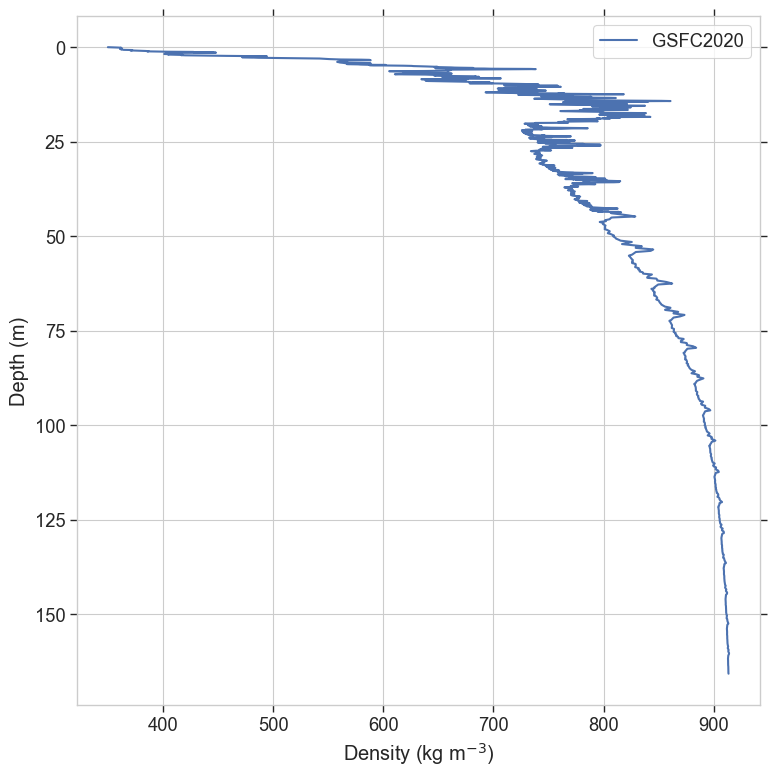

In [22]:
### Plot depth/density
f1,a1=plt.subplots(figsize=(8,8))
for rt in fns:
    a1.plot(rd[rt]['density'][-1,:],rd[rt]['depth'],label=rt)
a1.invert_yaxis()
a1.legend()
a1.set_xlabel('Density (kg m$^{-3}$)')
a1.set_ylabel('Depth (m)')

Text(0, 0.5, 'Firn Air content (m)')

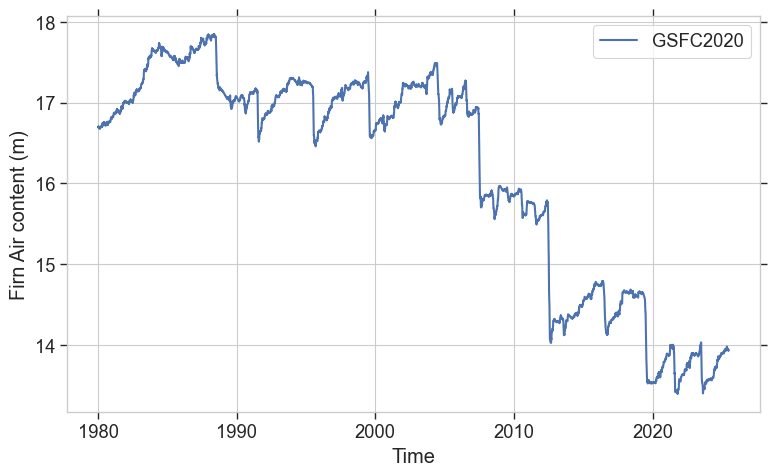

In [23]:
### Plot FAC through time
f1,a1=plt.subplots(figsize=(8,5))
for rt in fns:
    a1.plot(rd[rt]['model_time_vector'][:],rd[rt]['DIP'][:,0],label=rt)
a1.legend()
a1.set_xlabel('Time')
a1.set_ylabel('Firn Air content (m)')

Text(0, 0.5, 'change in Firn Air content (m)')

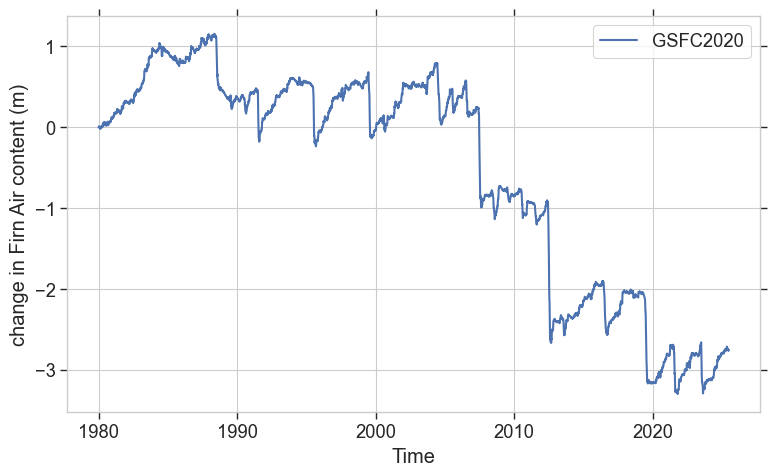

In [24]:
### Plot change in FAC through time
f1,a1=plt.subplots(figsize=(8,5))
for rt in fns:
    a1.plot(rd[rt]['model_time_vector'][:],rd[rt]['DIP'][:,0]-rd[rt]['DIP'][0,0] ,label=rt)
a1.legend()
a1.set_xlabel('Time')
a1.set_ylabel('change in Firn Air content (m)')